In [1]:
from tensorflow import keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np

## Constants and Functions

In [3]:
SEED = 121199
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 50
NUM_CLASSES = 5
BATCH_SIZE = 32

def visualize_result(his, epochs, filename):
    acc = his.history['accuracy']
    val_acc = his.history['val_accuracy']

    loss = his.history['loss']
    val_loss = his.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig(filename)
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=((6, 6)))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('img/' + title + '.png')

In [7]:
def create_graph(model_name, path_to_file, filename):
    fig, axs = plt.subplots(nrows=2, figsize=(8,5))
    plt.subplots_adjust(hspace = 0.3)
    fig.suptitle(model_name, fontsize=16)
    df = pd.read_csv(path_to_file)
    acc = df.iloc[:, lambda df: [0, 1, 3]]
    loss = df.iloc[:, lambda df: [0, 2, 4]]

    sns.lineplot(x='epoch', y='value', hue='variable', 
                data=pd.melt(loss, ['epoch']),
                palette=sns.color_palette('Set2', 2),
                ax=axs[0])
    plot = sns.lineplot(x='epoch', y='value', hue='variable', 
                data=pd.melt(acc, ['epoch']),
                palette=sns.color_palette('Set2', 2))

    axs[0].legend(loc='upper right', borderaxespad=0.4)
    axs[1].legend(loc='lower right', borderaxespad=0.4)
    fig.savefig('img/graph/' + filename + '.png', dpi=300)

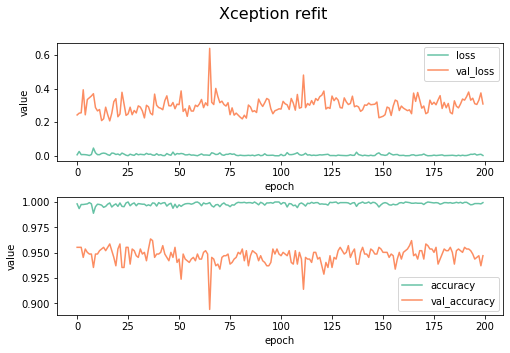

In [150]:
create_graph('Xception refit', 'logs/xception_refit.log', 'xception_refit')


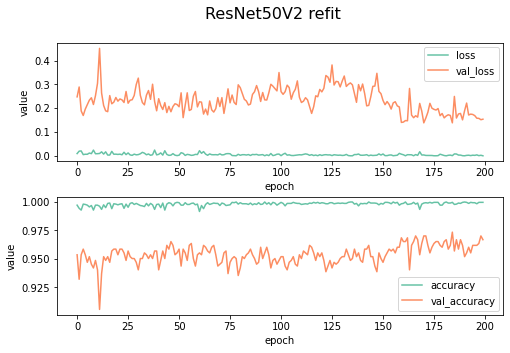

In [151]:
create_graph('ResNet50V2 refit', 'logs/resnet_refit.log', 'resnet_refit')

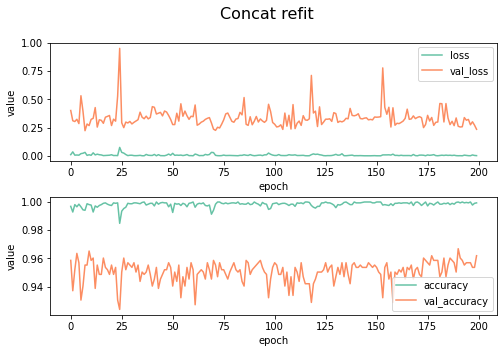

In [152]:
create_graph('Concat refit', 'logs/concat_refit.log', 'concat_refit')

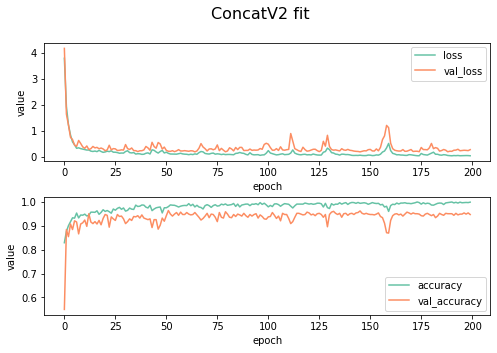

In [153]:
create_graph('ConcatV2 fit','logs/concat_reg_fit.log', 'concat_reg_fit')

## Custom Callbacks

In [8]:
import notifiers
import time
import datetime

class Notifier(tf.keras.callbacks.Callback):
    def __init__(self, model_name):
        super(Notifier, self).__init__()
        self.model_name = model_name
        self.token = 'av4arh4gjmz9x1i2t3oqanyfjxbchc'
        self.user = 'ua2ym7pyg7mjg71gzrdzusrd6hr7bu'
        self.pushover = notifiers.get_notifier('pushover')
        self.message = "{} training completed in {} \nVal Loss: {} | Val Accuracy: {}"
        print('model name: {}'.format(self.model_name))
        
    def on_training_begin(self, logs=None):
        self.start = time.time()

    def on_training_end(self, logs=None):
        self.end = time.time()
        runtime = datetime.timedelta(seconds=self.end - self.start)
        
        if logs:
            msg = self.message.format(self.model_name, runtime,
                                      round(logs['val_loss'], 3),
                                      round(logs['val_acc']*100, 3))
        else:
            msg = "{} training completed in {} \nLogs not found".format(self.model_name, runtime)
        print(msg)
        self.pushover.notify(message=msg, token=self.token, user=self.user)
        

## Acquire Data

In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import zipfile
# with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20)

test_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
)

val_ds = test_datagen.flow_from_directory(
    'dataset/val',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
)

test_ds = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=1,
    shuffle=False,
)

labels = list(test_ds.class_indices.keys())
labels

Found 3237 images belonging to 5 classes.
Found 604 images belonging to 5 classes.
Found 208 images belonging to 5 classes.


['dyskeratotic',
 'koilocytotic',
 'metaplastic',
 'parabasal',
 'superficialIntermediate']

## Model Architecture and HP Tuning

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

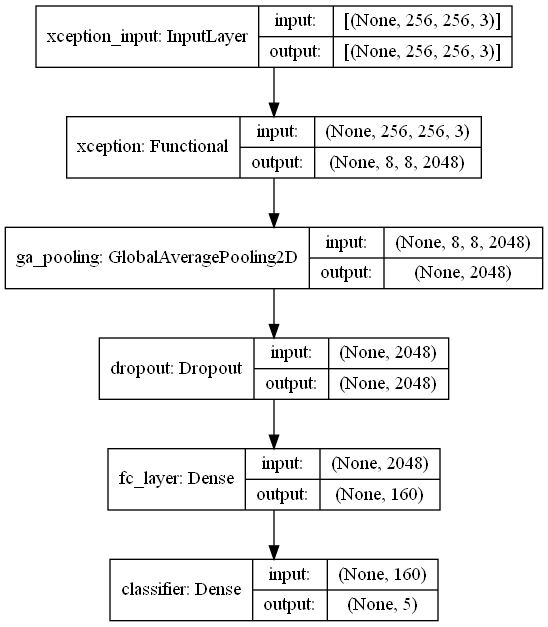

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.applications import Xception

xception_base = Xception(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
xception_base
for layer in xception_base.layers[:(len(xception_base.layers) - 16)]:
    layer.trainable = False
xception_base.summary()

xception_net = Sequential([
    xception_base,
    layers.GlobalAveragePooling2D(name='ga_pooling'),
    layers.Dropout(.3, seed=SEED, name='dropout'),
    layers.Dense(160, activation='tanh', name='fc_layer'),                                       # fully connected layers
    layers.Dense(NUM_CLASSES, activation='softmax', name='classifier')         # output layer
])

keras.utils.plot_model(xception_net, to_file="img/xception_arch.png", show_shapes=True)

## HP Tuning

In [ ]:
from kerastuner import HyperModel, HyperParameters, RandomSearch
import json

# -- CONVOLUTIONAL BASE -- #
xception_base = Xception(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# freeze all but last 2 separable conv block
for layer in xception_base.layers[:(len(xception_base.layers) - 16)]:
    layer.trainable = False

# -- HYPER MODEL -- #
class HyperCervixNet(HyperModel):
    def __init__(self):
        super().__init__()

    def build(self, hp):
        # hp search space
        fc_units = hp.Int('fc_units', min_value=32, max_value=512,
                          step=32, default=128)
        fc_activation = hp.Choice('fc_activation',
                                  values=['relu', 'tanh', 'sigmoid'],
                                  default='relu')
        dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.4,
                               step=0.1, default=0.3)
        
        # model assembly
        xception_net = Sequential([
            xception_base,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(dropout_rate, seed=SEED),
            layers.Dense(fc_units, activation=fc_activation),       # fully connected layers
            layers.Dense(NUM_CLASSES, activation='softmax')         # output layer
        ])
        
        # decaying learning rate
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-3,
            decay_steps=10000,
            decay_rate=0.9)
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
        # compile the model
        xception_net.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])
        return xception_net
    
hypermodel = HyperCervixNet()

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

import time
import datetime

# -- TUNER -- #
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 1
SEARCH_EPOCHS = 50

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search',
    project_name='xception',
)
tuner.search_space_summary()

tuning_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=1e-3, patience=10,
        mode='min', baseline=None, restore_best_weights=True)
]

start = time.time()
tuner.search(train_ds, epochs=SEARCH_EPOCHS, validation_data=val_ds, callbacks=tuning_callbacks)
end = time.time() - start
print('Xception hyperparameter search time: {}'.format(datetime.timedelta(seconds=end)))

# Show a summary of the search
tuner.results_summary()
best_hp = tuner.get_best_hyperparameters()[0]
with open('hp/xception_best_hp.json', 'w') as f:
    json.dump(best_hp.get_config(), f)
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('models/hp_search/xception_best_mt{}_ept{}_se{}.h5'.format(MAX_TRIALS, EXECUTION_PER_TRIAL, SEARCH_EPOCHS))

## Refitting the Model

model name: Xception Refit
Epoch 1/200
102/102 - 70s - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.2432 - val_accuracy: 0.9553
Epoch 2/200
102/102 - 65s - loss: 0.0260 - accuracy: 0.9935 - val_loss: 0.2539 - val_accuracy: 0.9553
Epoch 3/200
102/102 - 65s - loss: 0.0071 - accuracy: 0.9975 - val_loss: 0.2563 - val_accuracy: 0.9553
Epoch 4/200
102/102 - 65s - loss: 0.0076 - accuracy: 0.9975 - val_loss: 0.3932 - val_accuracy: 0.9454
Epoch 5/200
102/102 - 65s - loss: 0.0070 - accuracy: 0.9978 - val_loss: 0.2442 - val_accuracy: 0.9536
Epoch 6/200
102/102 - 65s - loss: 0.0052 - accuracy: 0.9981 - val_loss: 0.3350 - val_accuracy: 0.9503
Epoch 7/200
102/102 - 65s - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.3458 - val_accuracy: 0.9487
Epoch 8/200
102/102 - 65s - loss: 0.0078 - accuracy: 0.9981 - val_loss: 0.3562 - val_accuracy: 0.9487
Epoch 9/200
102/102 - 65s - loss: 0.0462 - accuracy: 0.9889 - val_loss: 0.3698 - val_accuracy: 0.9354
Epoch 10/200
102/102 - 65s - loss: 0.0180 - accuracy: 0

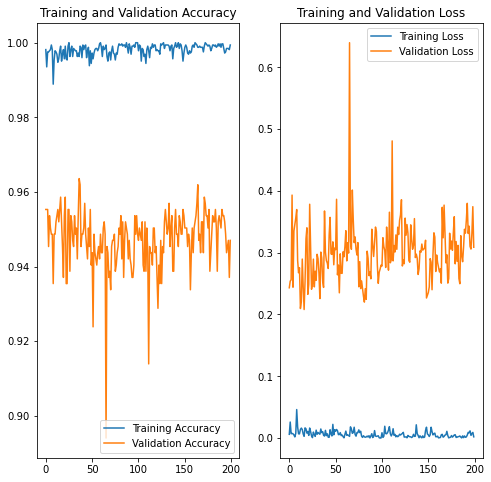

In [8]:
fit_callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss', min_delta=1e-4, patience=10,
#         mode='min', baseline=None, restore_best_weights=True),
    Notifier('Xception Refit'),
    tf.keras.callbacks.CSVLogger('logs/xception_refit.log')
]

start = time.time()
history = best_model.fit(train_ds, epochs=200, validation_data=val_ds, verbose=2, callbacks=fit_callbacks)
end = time.time() - start
print('Xception refit time: {}'.format(datetime.timedelta(seconds=end)))
n_epochs_best = len(history.history['val_loss'])

filename = 'xception_best_refit_e{}'.format(n_epochs_best)
best_model.save('models/{}.h5'.format(filename))
visualize_result(history, n_epochs_best, 'img/' + filename + '.png')

## Evaluating the Model

Confusion matrix, without normalization
[[41  1  0  0  0]
 [ 0 42  0  0  0]
 [ 0  1 40  0  0]
 [ 0  0  0 40  0]
 [ 0  0  0  0 43]]


0.9903846153846154

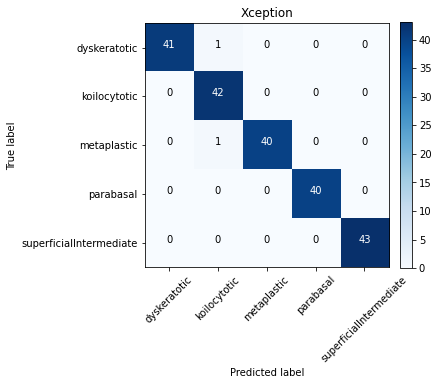

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
import numpy as np

y_true = test_ds.classes

model = keras.models.load_model('models/xception_best_refit_e200.h5')
y_pred = model.predict(test_ds)
rounded_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true=y_true, y_pred=rounded_pred)
plot_confusion_matrix(cm, labels, title="Xception")

accuracy_score(y_true, rounded_pred)

In [15]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

print(cm)
print(labels)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
# F1 score
F1 = 2*TP / (2*TP+FP+FN)

print("Sensitivity:", TPR)
print("Specificity:", TNR)
print("F1-score:", F1)

[[41  1  0  0  0]
 [ 0 42  0  0  0]
 [ 0  1 40  0  0]
 [ 0  0  0 40  0]
 [ 0  0  0  0 43]]
['dyskeratotic', 'koilocytotic', 'metaplastic', 'parabasal', 'superficialIntermediate']
Sensitivity: [0.97619048 1.         0.97560976 1.         1.        ]
Specificity: [1.         0.98795181 1.         1.         1.        ]
F1-score: [0.98795181 0.97674419 0.98765432 1.         1.        ]


## Extract Misclassified Images

In [5]:
model = keras.models.load_model('models/xception_best_refit_e200.h5')
y_pred = model.predict(test_ds)
rounded_pred = np.argmax(y_pred, axis=1)
print(rounded_pred)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


[ 41 109]
dataset\test\dyskeratotic\221_05.bmp
True: dyskeratotic, predicted: koilocytotic


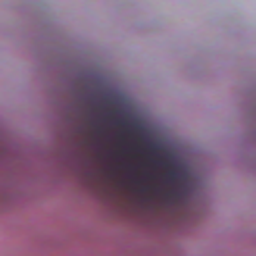

dataset\test\metaplastic\164_07.bmp
True: metaplastic, predicted: koilocytotic


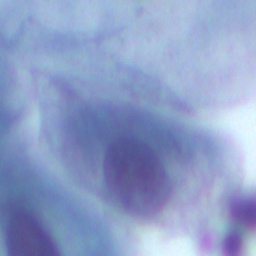

In [8]:
from PIL import Image
from shutil import copyfile

y_true = test_ds.classes
incorrects = np.nonzero(rounded_pred.reshape((-1,)) != y_true)
print(incorrects[0])

n_test = len(test_ds)
filenames = []

for root, dirs, files in os.walk("dataset\\test"):
    for file in files:
        filenames.append(os.path.join(root, file))

for i in incorrects[0]:
    path_to_file = filenames[i]

    img = Image.open(path_to_file)
    true_label = labels[y_true[i]]
    pred_label = labels[rounded_pred[i]]
    img = img.resize((256, 256))
    img.save("img\\misclassified\\xception\\{}_{}.png".format(true_label[:3], pred_label[:3]))
    print(path_to_file)
    print("True: {}, predicted: {}".format(true_label, pred_label))
    display(img)